In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
class PolicyNetwork(nn.Module):
  def __init__(self,num_actions,hidden_state,num_inputs,LR=1e-4):
    super(PolicyNetwork,self).__init__()
    self.num_actions=num_actions;
    self.Linear1=nn.Linear(num_inputs,hidden_state);
    self.Linear2=nn.Linear(hidden_state,num_actions);
    #self.Linear3=nn.Linear(hidden_state2,num_actions);
    self.optimizer=optim.Adam(self.parameters(),lr=LR);
  
  def forward(self,state):
    x=F.relu(self.Linear1(state));
    x=F.softmax(self.Linear2(x),dim=1);
    return x;

  def get_action(self,state):
    state=torch.from_numpy(state).float().unsqueeze(0);
    probs=self.forward(Variable(state));
    highest_prob_action=np.random.choice(self.num_actions,p=np.squeeze(probs.detach().numpy()));
    log_prob=torch.log(probs.squeeze(0)[highest_prob_action])
    return highest_prob_action,log_prob;

In [3]:
def update_policy(pol_net,rewards,log_probs,GAMMA):
  discounted_rewards=[];
  for t in range(len(rewards)):
    Gt=0;
    pw=0;
    for r in rewards[t:]:
      Gt=Gt+GAMMA**pw*r;
      pw+=1;
    discounted_rewards.append(Gt);
  discounted_rewards=torch.tensor(discounted_rewards);
  #discounted_rewards=(discounted_rewards-discounted_rewards.mean())/(discounted_rewards.std()+1e-8);
  policy_gradient=[];
  for log_prob,Gt in zip(log_probs,discounted_rewards):
    policy_gradient.append(-log_prob*Gt);
  pol_net.optimizer.zero_grad();
  policy_gradient=torch.stack(policy_gradient).sum();
  policy_gradient.backward();
  pol_net.optimizer.step();

In [8]:
def reinforce(env):
  GAMMA=0.5;
  max_episodes=300;
  length_of_episode=8000;
  epsilon=1e-7;
  rewards_per_episodes=[];
  pol_net=PolicyNetwork(env.action_space.n,128,env.observation_space.shape[0]);
  for episode in range(max_episodes):
    state=env.reset();
    rewards,log_probs=[],[];
    for _ in range(length_of_episode):
      #env.render()
      action,log_prob=pol_net.get_action(state);
      new_state,reward,done,_=env.step(action);
      log_probs.append(log_prob);
      rewards.append(reward);
      state=new_state;
      if done:
        break;
    update_policy(pol_net,rewards,log_probs,GAMMA);
    rewards_per_episodes.append(sum(rewards));
  rewards_per_episode=np.array(rewards_per_episodes);
  plt.plot(np.cumsum(rewards_per_episode)/np.arange(1,len(rewards_per_episode)+1));
  plt.xlabel('Episode');
  plt.ylabel('Cumulative Rewards');
  plt.show();

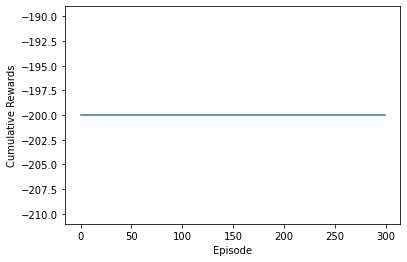

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
3


In [9]:
if __name__=='__main__':
  env=gym.make('MountainCar-v0')
  #env=gym.make('CartPole-v1')
  reinforce(env);
  print(env.observation_space)
  print(env.action_space.n)